# Classification
In this notebook we classify the CT/PET scans of lung cancer cases by tumor type. 
We are doing this as a baseline task to validate our data loading pipeline.
Most code is taken from [this tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from thermostability.thermo_dataset import ThermostabilityDataset

cudnn.benchmark = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    torch.cuda.empty_cache() 
    
cpu = torch.device("cpu")

torch.cuda.list_gpu_processes()

ModuleNotFoundError: No module named 'matplotlib'

# Defining datasets (train/validation) 

In [ ]:
trainSet = ThermostabilityDataset("data/train_sequences.fasta")
valSet = ThermostabilityDataset("data/eval_sequences.fasta")

dataloaders = {
    "train": torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=4),
    "val": torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=4)
}

dataset_sizes = {"train": len(trainSet),"val": len(valSet)}

# Defining model 

In [ ]:
from thermostability.hotinfer import HotInfer
model = HotInfer()
model.esmfold.requires_grad_(False)

model.to(device)

CapsNet(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (1): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (2): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (3): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (4): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (5): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (6): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (7): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (reconstraction_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_featur

# Setup training

In [ ]:
from tqdm.notebook import tqdm
import sys

def train_model(model, optimizer, criterion, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())

    best_epoch_loss = sys.float_info.max
    losses = []
    batchEnumeration = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
         

            # Iterate over data.
            for idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    loss = criterion(outputs,labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                batch_size = inputs.size(0)
                batch_loss = loss.item() * batch_size
                losses.append(batch_loss)
                batchEnumeration.append(batchEnumeration[-1]+1 if len(batchEnumeration)>0 else 0)

                running_loss += batch_loss
               
            
                if idx % 10 == 0:
                    batch_size = inputs.size(0)
                    tqdm.write("Epoch: [{}/{}], Batch: [{}/{}], train accuracy: {:.6f}, loss: {:.6f}".format(
                        epoch,
                        num_epochs,
                        idx + 1,
                        len(dataloaders[phase]),
                        batch_loss / float(batch_size)
                        ), end="\r")
                    
                    
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]


            print(f'{phase} Loss: {epoch_loss:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_loss < best_epoch_loss:
                best_epoch_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_epoch_loss:4f}')
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Define training parameters

In [ ]:
criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Run training

Epoch 0/9
----------
train Loss: 18.9435 Acc: 0.7027, train accuracy: 0.687500, loss: 16.910091
val Loss: 18.7073 Acc: 0.73450], train accuracy: 0.750000, loss: 18.077358

Epoch 1/9
----------
train Loss: 17.9900 Acc: 0.7343, train accuracy: 0.718750, loss: 14.712916
val Loss: 16.8119 Acc: 0.73450], train accuracy: 0.687500, loss: 17.709304

Epoch 2/9
----------
train Loss: 16.3725 Acc: 0.7343, train accuracy: 0.562500, loss: 14.705430
val Loss: 16.0910 Acc: 0.73450], train accuracy: 0.812500, loss: 17.232780

Epoch 3/9
----------
train Loss: 16.0084 Acc: 0.7343, train accuracy: 0.781250, loss: 17.190708
val Loss: 15.8161 Acc: 0.73450], train accuracy: 0.687500, loss: 18.516484

Epoch 4/9
----------
train Loss: 15.6775 Acc: 0.7343, train accuracy: 0.875000, loss: 11.434160
val Loss: 15.3765 Acc: 0.73450], train accuracy: 0.718750, loss: 13.697801

Epoch 5/9
----------
train Loss: 15.0167 Acc: 0.7343, train accuracy: 0.625000, loss: 13.509391
val Loss: 14.4553 Acc: 0.73450], train accur

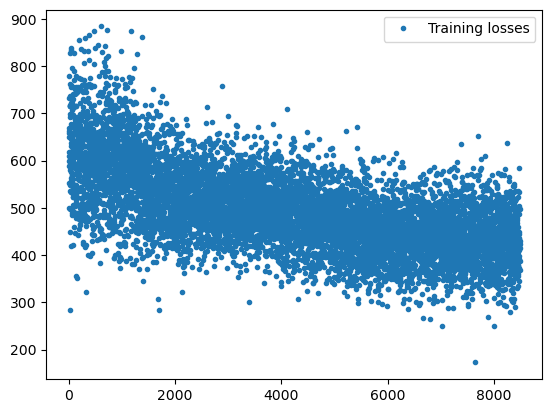

In [ ]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

# Evaluation

In [ ]:
x = np.arange(-5, 5, 0.001)

#define multiple normal distributions

def normal_dist(x , mean , sd):
    prob_density = (np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

diffs = np.array([0, 0.1, 0.2,-0.2, -0.8, 0.1])
sd = diffs.std()
mean = diffs.mean()
plt.plot(x, norm.pdf(x, mean, sd), label='μ: 0, σ: 1', color='gold')
plt.hist(diffs, 10)
plt.plot(diffs, normal_dist(diffs, mean, sd), 'o',label='datapoints', color='red')